In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [2]:
import matplotlib as mpl

In [3]:
from glob import glob

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
if not os.path.isdir('blogs'):
    
    !curl -OL 'https://huggingface.co/datasets/blog_authorship_corpus/resolve/main/data/blogs.zip?download=true'
    
    !unzip -q blogger-com-aug-2004.zip
    

In [7]:
blogs = glob('blogs/*.xml')

In [8]:
len(blogs)

19320

In [9]:
from tqdm import tqdm

In [10]:
import re

In [11]:
blog_texts = blogs
blog_texts = [open(b, 'rb').read().decode('cp1252', errors='ignore') for b in tqdm(blog_texts)]
blog_texts = [re.sub(r'[\r\n]', ' ', b) for b in tqdm(blog_texts)]
blog_texts = [re.sub(r'</post>', '</post>\r\n', b) for b in tqdm(blog_texts)]
blog_texts = [re.findall(r'<post>(.*)</post>', b) for b in tqdm(blog_texts)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19320/19320 [00:01<00:00, 17136.97it/s]


In [12]:
blog_texts = [p for b in tqdm(blog_texts) for p in b]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19320/19320 [00:00<00:00, 211406.34it/s]


In [13]:
len(blog_texts)

681288

In [14]:
post_text = blog_texts
post_text = [re.sub(r'[^\w\s]', r'', p.lower()) for p in post_text]
post_text[0]

'                  alright now please understand that firstly i am just a human being a little boy a single life in the big real world i dont really know of whom or whatsoever person will think about what i am about to write but my intension are as always the truth with no hard feeling towards anyone at all i had always been sincere to people whom i have met but sometime this kind of thing will just come and go so in words to say i have not yet found a actual soul mate yet only wish i could have  nbsp  i had always though the present girl during the time of the relationship will be a life soul mate but as obvious this doesnt turn out ot be true i had always put in my very best for my relationship but as most of everyone disappointment i had always fail to keep up the relationship there is no one else to blam except for myself i know i had been trying my best to keep my temper but we if you cant keep you just cant but what i say right now i am more clam than ever  nbsp  talking about te

In [15]:
post_text[0]

'                  alright now please understand that firstly i am just a human being a little boy a single life in the big real world i dont really know of whom or whatsoever person will think about what i am about to write but my intension are as always the truth with no hard feeling towards anyone at all i had always been sincere to people whom i have met but sometime this kind of thing will just come and go so in words to say i have not yet found a actual soul mate yet only wish i could have  nbsp  i had always though the present girl during the time of the relationship will be a life soul mate but as obvious this doesnt turn out ot be true i had always put in my very best for my relationship but as most of everyone disappointment i had always fail to keep up the relationship there is no one else to blam except for myself i know i had been trying my best to keep my temper but we if you cant keep you just cant but what i say right now i am more clam than ever  nbsp  talking about te

In [16]:
post_words = post_text
post_words = [p.split() for p in post_words]
post_words = [[w.strip() for w in p] for p in post_words]
post_words = [[w for w in p if len(w) > 0] for p in post_words]
post_words[0][:20]

['alright',
 'now',
 'please',
 'understand',
 'that',
 'firstly',
 'i',
 'am',
 'just',
 'a',
 'human',
 'being',
 'a',
 'little',
 'boy',
 'a',
 'single',
 'life',
 'in',
 'the']

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
len(post_words)

681288

In [19]:
sum([len(p) for p in post_words])

135834590

In [20]:
cleaned_texts = [' '.join(p) for p in post_words]

In [21]:
cv = CountVectorizer(min_df=1500)
cv.fit(cleaned_texts)
len(cv.vocabulary_)

4650

In [22]:
[(k, v) for k, v in cv.vocabulary_.items()][:20]

[('alright', 205),
 ('now', 2844),
 ('please', 3097),
 ('understand', 4324),
 ('that', 4123),
 ('am', 211),
 ('just', 2290),
 ('human', 2064),
 ('being', 459),
 ('little', 2476),
 ('boy', 582),
 ('single', 3724),
 ('life', 2440),
 ('in', 2118),
 ('the', 4127),
 ('big', 489),
 ('real', 3322),
 ('world', 4581),
 ('dont', 1263),
 ('really', 3330)]

In [23]:
vectorised_text = [
    [cv.vocabulary_.get(w, -1) for w in l] for l in tqdm(post_words)
]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 681288/681288 [00:32<00:00, 20982.69it/s]


In [24]:
import numpy as np

In [25]:
vectorised_text = [np.array(p) for p in vectorised_text]

In [26]:
[v[:20] for v in vectorised_text[:3]]

[array([ 205, 2844, 3097, 4324, 4123,   -1,   -1,  211, 2290,   -1, 2064,
         459,   -1, 2476,  582,   -1, 3724, 2440, 2118, 4127]),
 array([  -1, 1813,   -1, 4360,   -1, 4360, 4360,   -1, 2771, 1979, 3932,
        1420,   -1, 2290,  682, 3596, 4204, 1631, 4127, 2101]),
 array([2898, 4150,   -1, 1824, 4204, 4093, 4631,  293, 4123, 2091, 4631,
        1461, 4561, 4523,   -1, 3631, 4127, 1940, 2871, 4158])]

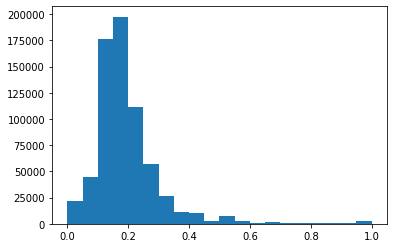

In [27]:
plt.hist([(p == -1).sum() / len(p) for p in vectorised_text if len(p) > 0], bins=20);

In [28]:
vectorised_text = [p[p >= 0] for p in vectorised_text]
vectorised_text = [p for p in vectorised_text if len(p > 0)]

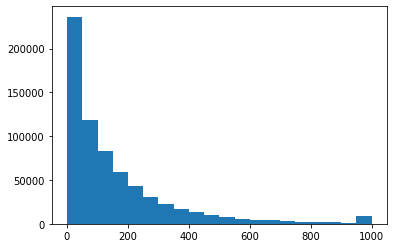

In [29]:
plt.hist(np.clip([len(p) for p in vectorised_text], None, 1000), bins=20);

In [30]:
vectorised_text = [p for p in vectorised_text if len(p) >= 100]

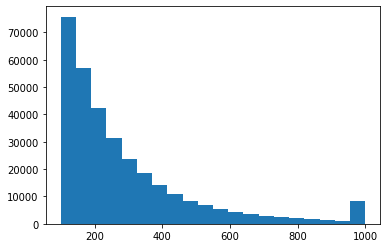

In [31]:
plt.hist(np.clip([len(p) for p in vectorised_text], None, 1000), bins=20);

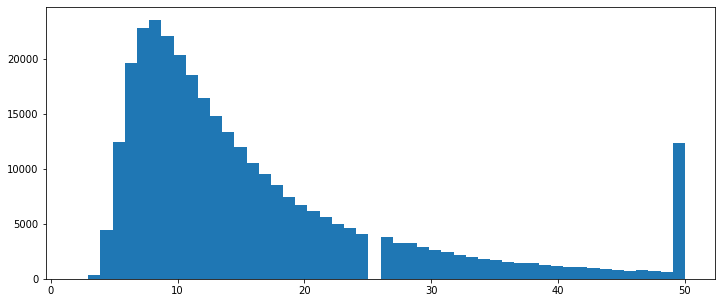

In [32]:
plt.figure(figsize=(12, 5))
plt.hist(np.clip([
    np.unique(p, return_counts=True)[1].max()
    for p in vectorised_text], 0, 50), bins=50);

In [33]:
cv_reverce_ix = {v: k for k, v in cv.vocabulary_.items()}

# KL text

In [34]:
min_len, max_len = 25, 150

In [35]:
seq_len_orig = np.array([len(p) for p in vectorised_text])
disjoint_split_point = np.where(
    seq_len_orig > 2 * min_len,
    (np.random.rand(len(seq_len_orig)) * (seq_len_orig - 2 * min_len)).astype(int) + min_len,
    (seq_len_orig / 2).astype(int),
)
seq_a = [p[:s] for p, s in zip(vectorised_text, disjoint_split_point)]
seq_b = [p[s:] for p, s in zip(vectorised_text, disjoint_split_point)]

In [36]:
def get_slice(seq):
    seq_len_orig = np.array([len(p) for p in seq])
    s_max_sample_len = np.clip(seq_len_orig.clip(0, max_len) - min_len, 0, None)
    s_len = (s_max_sample_len * np.random.rand(len(seq_len_orig))).astype(int) + min_len
    s_avl_pos = np.clip(seq_len_orig - s_len, 0, None)
    s_start = (s_avl_pos * np.random.rand(len(seq_len_orig))).astype(int)

    return [p[s: s + l] for p, s, l in zip(seq, s_start, s_len)]

In [37]:
' '.join([cv_reverce_ix.get(i) for i in seq_a[0]]), ' '.join([cv_reverce_ix.get(i) for i in seq_b[0]])

('alright now please understand that am just human being little boy single life in the big real world dont really know of whom or whatsoever person will think about what am about to write but my are as always the truth with no hard feeling towards anyone at all had always been to people whom have met but sometime this kind of thing will just come and go so in words to say have not yet found actual soul mate yet only wish could have nbsp had always though the present girl during the time of the relationship will be life soul mate but as obvious this doesnt turn out be true had always put in my very best for my relationship but as most of everyone disappointment had always fail to keep up the relationship there is no one else to except for myself know had been trying my best to keep my but we if you cant keep you just cant but what say right now am more than ever nbsp talking about sometime this wonders me you know why well cause every thing happen for reason some reason you just cannot 

In [38]:
seq_a = get_slice(seq_a)
seq_b = get_slice(seq_b)

In [39]:
' '.join([cv_reverce_ix.get(i) for i in seq_a[0]]), ' '.join([cv_reverce_ix.get(i) for i in seq_b[0]])

('out be true had always put in my very best for my relationship but as most of everyone disappointment had always fail to keep up the relationship there is no one else to except for myself know had been trying my best to keep my but we if you cant keep you just cant but what say right now am more than ever nbsp talking about sometime this wonders me you know why well cause every thing happen for reason some reason you just cannot explain but well do sometime thing that in way are good for you it do provide you with the to something someone else is not willing to give or forgot to give or enough',
 'have lot of whom is girl very very very close so close that most people think we are in relationship but simply we are the best of friends so well all could say are that know my true first girl by the way really feel and my planning ahead which have lie for both of us to some most will be as right now we are broken off nbsp my nbsp to be continue hopefully')

In [40]:
def _kl(a, b, verbose=False):
    a = {k: v / len(a) for k, v in zip(*np.unique(a, return_counts=True))}
    b = {k: v / len(b) for k, v in zip(*np.unique(b, return_counts=True))}

    d = {k: 0.0 if a.get(k, 0.0) == 0.0 else a.get(k, 0.0) * np.log(a.get(k, 1e-12) / b.get(k, 1e-12))
         for k in set(a.keys()).union(b.keys())}
    if verbose:
        print(sorted([(k, v) for k, v in d.items()], key=lambda x: -x[1]))
        
    return sum(d.values())


def kl_distribution(l_a, l_b):        
    return np.array([_kl(a, b) for a, b in tqdm(zip(l_a, l_b))])

In [41]:
kl_pos = kl_distribution(seq_a, seq_b)

322545it [00:51, 6262.61it/s]


In [42]:
ix_shuffle = np.random.choice(len(seq_a), len(seq_a), replace=False)
kl_neg = kl_distribution(seq_a, [seq_b[i] for i in ix_shuffle])

322545it [00:52, 6132.42it/s]


In [43]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [44]:
df = pd.concat([
        pd.DataFrame({'KL': kl_pos.clip(0, None),
                      'type': 'Same post sample'}),
        pd.DataFrame({'KL': kl_neg.clip(0, None), 
                      'type': 'Random post sample'}),
    ], axis=0).reset_index(drop=True)

In [45]:
len(df)

645090

In [46]:
df.sample(frac=0.1).to_parquet('figures/kl_dis_text.parquet')

In [47]:
!ls -lh figures/kl_dis_text.parquet

-rw-rw-r-- 1 kireev kireev 1.1M Jul 28 18:10 figures/kl_dis_text.parquet


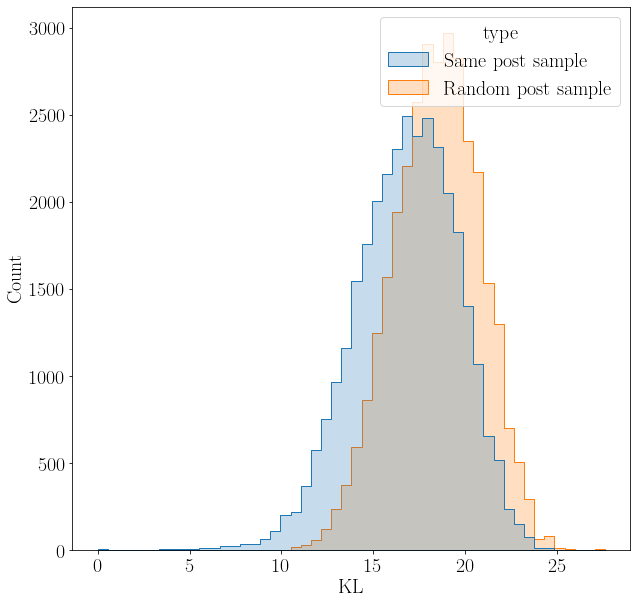

In [48]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(10, 10))
    mpl.rc('font', size=20)

    sns.histplot(pd.read_parquet('figures/kl_dis_text.parquet'), x="KL", hue="type", bins=50, element='step')

    # plt.title('Age group')
    mpl.pyplot.savefig('figures/kl_dis_text.pdf', format='pdf', bbox_inches='tight')
    # plt.show()